<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_autoencoders_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial autoencoders for text

Code is from
https://github.com/shentianxiao/text-autoencoders

Paper is here: https://arxiv.org/pdf/1905.12777.pdf

# Setup

In [1]:
import torch
from multiprocessing import cpu_count

print(cpu_count())
print(torch.cuda.is_available())

4
True


In [2]:
!git clone https://github.com/shentianxiao/text-autoencoders.git

Cloning into 'text-autoencoders'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 114 (delta 11), reused 12 (delta 4), pack-reused 83
Receiving objects: 100% (114/114), 270.78 KiB | 12.89 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
!ls

sample_data  text-autoencoders


In [4]:
%cd text-autoencoders

/content/text-autoencoders


In [5]:
!ls

batchify.py	  img	   meter.py  noise.py	test.py   utils.py
download_data.sh  LICENSE  model.py  README.md	train.py  vocab.py


# Data

In [6]:
!bash download_data.sh

--2021-07-14 03:10:28--  http://people.csail.mit.edu/tianxiao/data/yelp.zip
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3676642 (3.5M) [application/zip]
Saving to: ‘yelp.zip’

yelp.zip            100%[===================>]   3.51M  3.66MB/s    in 1.0s    

2021-07-14 03:10:29 (3.66 MB/s) - ‘yelp.zip’ saved [3676642/3676642]

Archive:  yelp.zip
   creating: yelp/
   creating: yelp/tense/
  inflating: yelp/tense/valid.past   
  inflating: yelp/tense/valid.present  
  inflating: yelp/tense/test.past    
  inflating: yelp/tense/test.present  
   creating: yelp/sentiment/
  inflating: yelp/sentiment/100.neg  
  inflating: yelp/sentiment/100.pos  
  inflating: yelp/sentiment/1000.neg  
  inflating: yelp/sentiment/1000.pos  
  inflating: yelp/test.txt           
  inflating: yelp/train.txt          
  inflating: yelp/valid.tx

# Train

In [7]:
!python train.py -h

usage: train.py [-h] --train FILE --valid FILE [--save-dir DIR]
                [--load-model FILE] [--vocab-size N] [--dim_z D] [--dim_emb D]
                [--dim_h D] [--nlayers N] [--dim_d D] [--model_type M]
                [--lambda_kl R] [--lambda_adv R] [--lambda_p R]
                [--noise P,P,P,K] [--dropout DROP] [--lr LR] [--epochs N]
                [--batch-size N] [--seed N] [--no-cuda] [--log-interval N]

optional arguments:
  -h, --help         show this help message and exit
  --train FILE       path to training file
  --valid FILE       path to validation file
  --save-dir DIR     directory to save checkpoints and outputs
  --load-model FILE  path to load checkpoint if specified
  --vocab-size N     keep N most frequent words in vocabulary
  --dim_z D          dimension of latent variable z
  --dim_emb D        dimension of word embedding
  --dim_h D          dimension of hidden state per layer
  --nlayers N        number of layers
  --dim_d D          dimension o

In [8]:
"""
# Path arguments
parser.add_argument('--train', metavar='FILE', required=True,
                    help='path to training file')
parser.add_argument('--valid', metavar='FILE', required=True,
                    help='path to validation file')
parser.add_argument('--save-dir', default='checkpoints', metavar='DIR',
                    help='directory to save checkpoints and outputs')
parser.add_argument('--load-model', default='', metavar='FILE',
                    help='path to load checkpoint if specified')
# Architecture arguments
parser.add_argument('--vocab-size', type=int, default=10000, metavar='N',
                    help='keep N most frequent words in vocabulary')
parser.add_argument('--dim_z', type=int, default=128, metavar='D',
                    help='dimension of latent variable z')
parser.add_argument('--dim_emb', type=int, default=512, metavar='D',
                    help='dimension of word embedding')
parser.add_argument('--dim_h', type=int, default=1024, metavar='D',
                    help='dimension of hidden state per layer')
parser.add_argument('--nlayers', type=int, default=1, metavar='N',
                    help='number of layers')
parser.add_argument('--dim_d', type=int, default=512, metavar='D',
                    help='dimension of hidden state in AAE discriminator')
# Model arguments
parser.add_argument('--model_type', default='dae', metavar='M',
                    choices=['dae', 'vae', 'aae'],
                    help='which model to learn')
parser.add_argument('--lambda_kl', type=float, default=0, metavar='R',
                    help='weight for kl term in VAE')
parser.add_argument('--lambda_adv', type=float, default=0, metavar='R',
                    help='weight for adversarial loss in AAE')
parser.add_argument('--lambda_p', type=float, default=0, metavar='R',
                    help='weight for L1 penalty on posterior log-variance')
parser.add_argument('--noise', default='0,0,0,0', metavar='P,P,P,K',
                    help='word drop prob, blank prob, substitute prob'
                         'max word shuffle distance')
# Training arguments
parser.add_argument('--dropout', type=float, default=0.5, metavar='DROP',
                    help='dropout probability (0 = no dropout)')
parser.add_argument('--lr', type=float, default=0.0005, metavar='LR',
                    help='learning rate')
#parser.add_argument('--clip', type=float, default=0.25, metavar='NORM',
#                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='number of training epochs')
parser.add_argument('--batch-size', type=int, default=256, metavar='N',
                    help='batch size')
# Others
parser.add_argument('--seed', type=int, default=1111, metavar='N',
                    help='random seed')
parser.add_argument('--no-cuda', action='store_true',
                    help='disable CUDA')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='report interval')
"""

"\n# Path arguments\nparser.add_argument('--train', metavar='FILE', required=True,\n                    help='path to training file')\nparser.add_argument('--valid', metavar='FILE', required=True,\n                    help='path to validation file')\nparser.add_argument('--save-dir', default='checkpoints', metavar='DIR',\n                    help='directory to save checkpoints and outputs')\nparser.add_argument('--load-model', default='', metavar='FILE',\n                    help='path to load checkpoint if specified')\n# Architecture arguments\nparser.add_argument('--vocab-size', type=int, default=10000, metavar='N',\n                    help='keep N most frequent words in vocabulary')\nparser.add_argument('--dim_z', type=int, default=128, metavar='D',\n                    help='dimension of latent variable z')\nparser.add_argument('--dim_emb', type=int, default=512, metavar='D',\n                    help='dimension of word embedding')\nparser.add_argument('--dim_h', type=int, default

In [9]:
NUM_EPOCHS = 1  # debugging
!python train.py --epochs $NUM_EPOCHS --train data/yelp/train.txt --valid data/yelp/valid.txt --model_type aae --lambda_adv 10 --noise 0.3,0,0,0 --save-dir checkpoints/yelp/daae

Namespace(batch_size=256, dim_d=512, dim_emb=512, dim_h=1024, dim_z=128, dropout=0.5, epochs=1, lambda_adv=10.0, lambda_kl=0, lambda_p=0, load_model='', log_interval=100, lr=0.0005, model_type='aae', nlayers=1, no_cuda=False, noise=[0.3, 0.0, 0.0, 0.0], save_dir='checkpoints/yelp/daae', seed=1111, train='data/yelp/train.txt', valid='data/yelp/valid.txt', vocab_size=10000)
# train sents 200000, tokens 1821469
# valid sents 10000, tokens 90833
# vocab size 10005
# model parameters: 34933782
--------------------------------------------------------------------------------
| epoch   1 |   100/  790 batches | rec 72.15, adv 0.92, |lvar| 157.64, loss_d 1.52, loss 81.37,
| epoch   1 |   200/  790 batches | rec 61.28, adv 0.80, |lvar| 368.74, loss_d 1.55, loss 69.28,
| epoch   1 |   300/  790 batches | rec 57.19, adv 0.91, |lvar| 314.87, loss_d 1.40, loss 66.32,
| epoch   1 |   400/  790 batches | rec 58.70, adv 0.60, |lvar| 254.65, loss_d 1.40, loss 64.66,
| epoch   1 |   500/  790 batches | r

In [ ]:
NUM_EPOCHS = 10  # debugging
!python train.py --epochs $NUM_EPOCHS --train data/yelp/train.txt --valid data/yelp/valid.txt --model_type aae --lambda_adv 10 --noise 0.3,0,0,0 --save-dir checkpoints/yelp/daae

Namespace(batch_size=256, dim_d=512, dim_emb=512, dim_h=1024, dim_z=128, dropout=0.5, epochs=10, lambda_adv=10.0, lambda_kl=0, lambda_p=0, load_model='', log_interval=100, lr=0.0005, model_type='aae', nlayers=1, no_cuda=False, noise=[0.3, 0.0, 0.0, 0.0], save_dir='checkpoints/yelp/daae', seed=1111, train='data/yelp/train.txt', valid='data/yelp/valid.txt', vocab_size=10000)
# train sents 200000, tokens 1821469
# valid sents 10000, tokens 90833
# vocab size 10005
# model parameters: 34933782
--------------------------------------------------------------------------------
| epoch   1 |   100/  790 batches | rec 72.15, adv 0.92, |lvar| 157.64, loss_d 1.52, loss 81.37,
| epoch   1 |   200/  790 batches | rec 61.28, adv 0.80, |lvar| 368.74, loss_d 1.55, loss 69.28,
| epoch   1 |   300/  790 batches | rec 57.19, adv 0.91, |lvar| 314.87, loss_d 1.40, loss 66.32,
| epoch   1 |   400/  790 batches | rec 58.70, adv 0.60, |lvar| 254.65, loss_d 1.40, loss 64.66,
| epoch   1 |   500/  790 batches | 

In [12]:
!ls

batchify.py  download_data.sh  meter.py  __pycache__  train.py
checkpoints  img	       model.py  README.md    utils.py
data	     LICENSE	       noise.py  test.py      vocab.py


In [13]:
!ls checkpoints/yelp/daae

log.txt  model.pt  vocab.txt


In [ ]:
from google.colab import files

# files.download('checkpoints/yelp/daae/model.pt')

# Upload pretrained model

In [ ]:
from google.colab import files

# uploaded = files.upload() # store it in checkpoints/yelp/daae/model.pt

# Reconstruction

In [14]:
!python test.py --reconstruct --data data/yelp/test.txt --output test.rec --checkpoint checkpoints/yelp/daae/



In [15]:
!ls checkpoints/yelp/daae

log.txt  model.pt  test.rec.rec  test.rec.z  vocab.txt


In [16]:
!head checkpoints/yelp/daae/test.rec.rec

the food is the
the food .
i was the <unk> .
i was the <unk> .
the was .
i was the <unk> .
i was the <unk> .
the was .
i was the <unk> .
the food is the


In [ ]:
!head checkpoints/yelp/daae/test.rec.z

0.094768 -0.291090 -0.489985 0.202093 0.117203 -0.806483 0.181313 0.153859 -0.704442 0.698928 -1.055091 0.777047 0.117410 0.014868 -1.339213 -0.221679 0.042334 0.606998 -0.376029 -0.751561 0.107382 0.644721 -0.000460 0.872706 -0.087044 -0.579721 0.411608 -0.185749 -0.554745 0.604862 -0.731883 -0.309543 -0.016051 -0.578636 0.659351 -0.709625 0.038995 0.502465 -0.001106 -0.520677 0.694700 0.066660 -0.088520 -0.091965 0.098838 0.115278 -1.166481 -0.523997 0.153134 -0.076340 0.842360 -0.698873 0.435798 -1.878466 0.261303 0.089877 -0.620121 0.330970 -0.032149 0.696021 0.999824 0.721442 1.245590 -0.445772 1.051999 0.326336 -0.854949 -0.545385 0.075077 0.738972 -0.148082 -0.060089 -0.085434 -0.683974 -0.152279 0.153202 -1.588573 -1.088758 0.249445 0.497600 0.719089 1.306792 -0.319849 -0.097299 0.345759 -0.136131 0.001014 0.306229 0.593422 -0.243222 0.560697 0.096621 0.760783 -0.492208 -0.058051 1.178401 0.152416 -0.979651 0.732733 0.021835 -0.461662 0.118697 1.805571 -0.249457 0.196653 0.1276

In [ ]:
!head data/yelp/test.txt

husband loves the thin crust pizza .
breadsticks are great too
monicals pizza is by far one of my favorite pizzas .
the traditional thin crust topped with sausage and pinnaple it where its at .
i also like this location .
it has two levels which gives is a more homey feeeling .
and more unbelievably the pizza served was missing a portion .
the reason ?
`` the oven ate it '' - according to the waitress .
absolutely love their thin crust pizzas .


# Sample

In [ ]:
!python test.py --sample --n 10 --output sample --checkpoint checkpoints/yelp/daae/

In [ ]:
!ls checkpoints/yelp/daae

log.txt  model.pt  sample  test.rec.rec  test.rec.z  vocab.txt


In [ ]:
!head checkpoints/yelp/daae/sample

so know !
the <unk> that was n't <unk> that was a good thing !
the <unk> have to eat home , too .
for a _num_ night , a decent size of their wine list .
the owner was awesome , and i will never recommend them again !
very romantic restaurant in the staff was beyond <unk> !
prices though are pretty weak but the prices are low .
the goat cheese is also a bit of the last time .
the staff here are always nice .
very nice , and no complaints , but the entire experience .


# Arithmetic

The difference between the average latent representation of the first two data files will be applied to the third file (separated by commas), and k denotes the scaling factor.


## Tense

In [ ]:
!python test.py --arithmetic --data data/yelp/tense/valid.past,data/yelp/tense/valid.present,data/yelp/tense/test.past --output test.past2present --checkpoint checkpoints/yelp/daae/



In [ ]:
!head data/yelp/tense/valid.past

overpriced .
the pizza was pretty bland , despite a hefty helping of oregano .
perhaps because i was indoctrinated into loving this pizza as a small child .
we got the thin crust with steak and bacon and it was awesome !
i had to knock it down a star .
the food was n't good .
went here after a doctors appointment one day .
the pizza was good .
the small salad was n't their best .
the service sucked .


In [ ]:
!head data/yelp/tense/valid.present

pizza is pretty good !
everything is usually pretty fresh and hot .
there is something about this pizza that is addictive .
there is very little sauce , fairly dry cheese , and a chewy crust .
i do n't know what to call it ... .
because every local i know loves monicals .
in fact , they even sell their french dressing online !
seriously , i 've looked . )
the pizza is pretty good , but not the best in champaign-urbana .
i prefer papa del 's .


In [ ]:
!head data/yelp/tense/test.past

and more unbelievably the pizza served was missing a portion .
`` the oven ate it '' - according to the waitress .
reasonably priced .
could n't be more happy with their service either .
they could use a fork upgrade , but the rice was nice .
i got the garlic chicken with vegetables with lo mein .
paid over $ _ num _ and it was pretty greasy and just very underwhelming .
i walked in and briefly fingered coats , feeling lost and confused .
`` have you spent a winter here before ? ''
she asked , eyeing my confused expression .


In [ ]:
!head checkpoints/yelp/daae/test.past2present

even as the cheese and it was a little variety .
`` the burger '' it 's : not the to say .
reasonably priced .
i might not have many good customer service either .
they should have a difference , but the bread was nice .
i got the garlic chicken with fresh and sour .
i paid on <unk> <unk> and it 's pretty <unk> and very good .
i walked in <unk> , and <unk> in a hurry and leave .
`` you have a reservation here in here ? ''
she said , <unk> my <unk> .


## Sentiment

In [ ]:
!python test.py --arithmetic --k 2 --data data/yelp/sentiment/100.neg,data/yelp/sentiment/100.pos,data/yelp/sentiment/1000.neg --output 1000.neg2pos --checkpoint checkpoints/yelp/daae/

In [ ]:
!head data/yelp/sentiment/100.neg

the $ _num_ minimum charge to use a credit card is also annoying .
sorry but i do n't get the rave reviews for this place .
the desserts were very bland .
the cake portion was extremely light and a bit dry .
it was super dry and had a weird taste to the entire slice .
once again , i have n't figured out why they change so much .
consistently slow .
even in the awkward freezer burn then microwaved scent .
so nasty .
i hate mayonnaise .


In [ ]:
!head data/yelp/sentiment/100.pos

excellent chinese and superb service .
my favorite chinese food in az !
it 's full of fresh ingredients , light and tasty .
we had the shrimp with vegetables and shrimp fried rice - both lovely .
they 're quite generous with the shrimp !
i had christmas dinner at george 's and thought it to be the best .
as i said , best ever !
did n't know this type cuisine could be this great !
go there , eat , enjoy !
best chinese food i 've had in a long time .


In [ ]:
!head data/yelp/sentiment/1000.neg

the answer was none .
this place sucks .
we have been there _num_ times , with an attempted 3rd time .
1st time , burnt pizza , was horrible .
wo n't go back .
also like all spinatos they are closed on monday .
the food was bland ... if you like spinatos , just avoid this location .
it 's not worth it .
friendly staff , but not overly helpful .
we got the thicker crust and it tasted really dry and hard .


In [ ]:
!head checkpoints/yelp/daae/1000.neg2pos

the staff is excellent .
this place is phenomenal .
we have been here for a nice , and both with our time .
our experience , the pizza was fantastic .
we will definitely go back .
also love all and <unk> are on sunday .
the food is delicious , and it is not good at this place .
it 's always worth it .
friendly staff , friendly and helpful .
we had the italian crust and it was really fresh and fresh .


# Interpolation

Sentence interpolation between two data files (separated by a comma), 


In [ ]:
!python test.py --interpolate --data data/yelp/interpolate/example.long,data/yelp/interpolate/example.short --output example.int --checkpoint checkpoints/yelp/daae/

In [ ]:
!head checkpoints/yelp/daae/example.int

i highly recommend it and i will be back !
i highly recommend it and i will be back !
i will definitely be back !
i will be back !
i will be back !

probably the worst chinese food i 've ever had in my life .
probably the worst chinese food i 've ever had in my life .
worst chinese chinese food .
worst chinese food .


In [ ]:
!head data/yelp/interpolate/example.long

i highly recommend it and i 'll definitely be back !
probably the worst chinese food i 've had in my life .
i say again , do n't ever stay at this hotel !
it 's so much better than the other chinese food places in this area .
the fried dumplings are a must if you ever visit this place .
definitely worth going for if you want good quick chinese food .
everyone who works there is very sweet and genuine too !
this was the must disgusting restaurant i have eaten at in years .
this is one of my favorite restaurants in town .
literally the best place for students and locals who want diversity in their food .


In [ ]:
!head data/yelp/interpolate/example.short

i will be back !
worst chinese food .
do n't stay !
better than other places .
fried dumplings are a must .
definitely worth going !
everyone is sweet !
disgusting !
my favorite !
the best !


# Optiponal: Reproduce fig 1 (toy dataset)

The code below was sent to me by Tianxiao.
It is not part of the repo.

## Make dataset

In [20]:
import os
import random

random.seed(1)


def gen(path, n=5, m=100, l=50, p=0.2):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        for i in range(n):
            c = [random.randint(0, 1) for _ in range(l)]
            for j in range(m):
                b = c.copy()
                for k in range(l):
                    if random.random() < p:
                        b[k] = 1 - b[k]
                f.write(" ".join([str(x) for x in b]) + "\n")


gen("data/toy/data.txt")

## Train

In [21]:
!python train.py --train data/toy/data.txt --valid data/toy/data.txt --model_type aae --lambda_adv 10 --dim_z 2 --save-dir checkpoints/toy/aae/ --epochs 1

Namespace(batch_size=256, dim_d=512, dim_emb=512, dim_h=1024, dim_z=2, dropout=0.5, epochs=1, lambda_adv=10.0, lambda_kl=0, lambda_p=0, load_model='', log_interval=100, lr=0.0005, model_type='aae', nlayers=1, no_cuda=False, noise=[0.0, 0.0, 0.0, 0.0], save_dir='checkpoints/toy/aae/', seed=1111, train='data/toy/data.txt', valid='data/toy/data.txt', vocab_size=10000)
# train sents 500, tokens 25000
# valid sents 500, tokens 25000
# vocab size 7
# model parameters: 18921484
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   1 | time     1s | valid rec 72.48, adv 0.72, |lvar| 0.10, loss_d 1.39, loss 79.63, | saving model
Done training


In [23]:
!python train.py --train data/toy/data.txt --valid data/toy/data.txt --model_type dae --lambda_adv 10 --dim_z 2 --noise 0,0,0.2,0 --save-dir checkpoints/toy/daae/ --epochs 1

Namespace(batch_size=256, dim_d=512, dim_emb=512, dim_h=1024, dim_z=2, dropout=0.5, epochs=1, lambda_adv=10.0, lambda_kl=0, lambda_p=0, load_model='', log_interval=100, lr=0.0005, model_type='dae', nlayers=1, no_cuda=False, noise=[0.0, 0.0, 0.2, 0.0], save_dir='checkpoints/toy/daae/', seed=1111, train='data/toy/data.txt', valid='data/toy/data.txt', vocab_size=10000)
# train sents 500, tokens 25000
# valid sents 500, tokens 25000
# vocab size 7
# model parameters: 18919435
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   1 | time     1s | valid rec 77.14, loss 77.14, | saving model
Done training


In [28]:
!ls checkpoints/toy/aae

log.txt  model.pt  vocab.txt


## Compute latent representations

In [29]:
!python test.py --reconstruct --data data/toy/data.txt --output data --max-len 55 --checkpoint checkpoints/toy/aae/

In [30]:
!python test.py --reconstruct --data data/toy/data.txt --output data --max-len 55 --checkpoint checkpoints/toy/daae/

## Plot

In [25]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.manifold import TSNE


def plot_z(filename):
    x = []
    with open(filename) as f:
        for line in f:
            parts = line.split()
            x.append([float(p) for p in parts])
    x = np.array(x)
    # x = TSNE().fit_transform(x)

    n, m = 5, 100
    for i in range(n):
        l, r = i * m, (i + 1) * m
        plt.scatter(x[l:r, 0], x[l:r, 1])

    # plt.title('DAAE', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

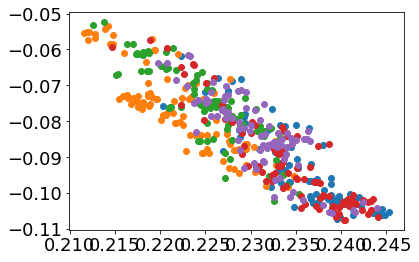

In [31]:
plot_z("checkpoints/toy/aae/data.z")

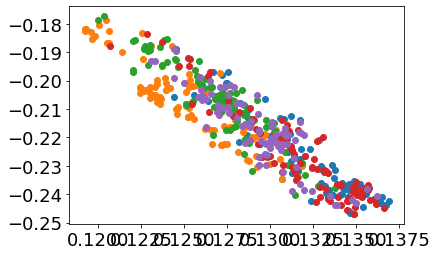

In [33]:
plot_z("checkpoints/toy/daae/data.z")